# System Modeling: Flyball Governor

## Preparations

In [29]:
from IPython.display import HTML
import numpy as np
import base64


import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 10,
})

from sympy import *

from mathprint import *

# https://stackoverflow.com/questions/49145059/how-to-change-printed-representation-of-functions-derivative-in-sympy
latexReplaceRules = {
    # r'{\left(t \right)}':r' ',
    r'\frac{d}{d t}':r'\dot',
    r'\frac{d^{2}}{d t^{2}}':r'\ddot',
}

def latexNew(expr,**kwargs):
    retStr = latex(expr,**kwargs)
    for _,__ in latexReplaceRules.items():
        retStr = retStr.replace(_,__)
    return retStr


init_printing(use_unicode=False)
init_printing(latex_printer=latexNew)


def display_gif(fn):
    b64 = base64.b64encode(open(fn,'rb').read()).decode('ascii');
    display(HTML(f'<img src="data:image/gif;base64,{b64}" />'));

Declare the necessary symbols:

In [30]:
t = symbols('t', real=True)
theta1 = Function('theta1')
theta2 = Function('theta2')
tau    = symbols('tau', real=True)
J, m, l, d, g, b1, b2 = symbols('J m l d g b1 b2', real=True, nonnegative=True)

![|0.4](./images/flyball.png)

## Kinetic energy

Let us describe the two motions that contribute to kinetic energy:
* upward-downward rotations around $\theta_1$ $\rightarrow T_1$
* planar continous rotations around $\theta_2$ $\rightarrow T_2$

Note that we use __parallel axis theorem__ to compute the get the correct momen of inertia about the given rotation axis.

In [31]:
T1 = simplify( 2*1/2*(J+m*l**2)*diff(theta1(t) ,t)**2 )
T2 = simplify( 2*1/2*(J+m*(l*sin(theta1(t))+d)**2)*diff(theta2(t) ,t)**2 )

mprint('T_1=' + latexNew(T1))
mprint('T_2=' + latexNew(T2))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Potential energy

In [32]:
V = 2*m*g*l*(1-cos(theta1(t)))

mprint('V=' + latexNew(V))


<IPython.core.display.Math object>

## Dissipassion

We introudce two damping elements that cause energy lost:
* $R_1$: dissipation by the linear bushing moving along the vertical rod.
* $R_2$: dissipation by the rotating vertical rod.

In [33]:
z    = l-l*cos(theta1(t))
zdot = diff(z, t)

R1 = 1/2*b1*zdot**2
R2 = 1/2*b2*diff(theta2(t))**2

mprint('R_1=' + latexNew(R1))
mprint('R_2=' + latexNew(R2))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Euler–Lagrange equations

Now, we shall derive the Euler-Lagrange euqations step by step.

In [34]:
T = T1 + T2  # Total kinetic energy
L = T  - V   # The Lagrangian

dL_dTh = Matrix([diff(L, theta1(t)), diff(L, theta2(t))])

mprint('\\frac{dL}{d\\theta}=' + latexNew(dL_dTh))

<IPython.core.display.Math object>

In [35]:
dL_dThdot = simplify(Matrix([diff(L, diff(theta1(t), t)), diff(L, diff(theta2(t), t))]))

mprint('\\frac{dL}{d\\dot{\\theta}}=' + latexNew(dL_dThdot) )

<IPython.core.display.Math object>

In [36]:
dR1_dThdot = simplify(Matrix([diff(R1, diff(theta1(t), t)), diff(R1, diff(theta2(t), t))]))

mprint('\\frac{dR_1}{d\\dot{\\theta}}=' + latexNew(dR1_dThdot) )

<IPython.core.display.Math object>

In [37]:
dR2_dThdot = simplify(Matrix([diff(R2, diff(theta1(t), t)), diff(R2, diff(theta2(t), t))]))

mprint('\\frac{dR_2}{d\\dot{\\theta}}=' + latexNew(dR2_dThdot) )

<IPython.core.display.Math object>

In [38]:
dL_dThdot_dt = simplify(Matrix([diff(diff(L, diff(theta1(t), t)),t) , diff(diff(L, diff(theta2(t), t)), t)]))
mprint('\\frac{dL}{d\\dot{\\theta} dt}=' + latexNew(dL_dThdot_dt) )


<IPython.core.display.Math object>

In [39]:
eq = simplify(dL_dThdot_dt - dL_dTh + dR1_dThdot + dR2_dThdot)

mprint('\\frac{dL}{d\\dot{\\theta} dt} - \\frac{dL}{d\\theta} + \\frac{dR_1}{d\\dot{\\theta}} + \\frac{dL}{d\\dot{\\theta} dt}=' + latexNew(eq) )


<IPython.core.display.Math object>

## Equation of motions

By rewriting the Euler-Lagrange equations, we can then express the system's equation of motions.

In [40]:
eqs = Eq(eq, Matrix([0 , tau]))

In [41]:
odes = solve(eqs, [diff(theta1(t), t, t), diff(theta2(t), t, t)])

In [42]:
ode1 = simplify(odes[diff(theta1(t), t, t)])
mprintb(" \\ddot{\\theta_1}(t) = ", latexNew(ode1))

<IPython.core.display.Math object>

In [43]:
ode2 = simplify(odes[diff(theta2(t), t, t)])
mprintb(" \\ddot{\\theta_1}(t) = ", latexNew(ode2))

<IPython.core.display.Math object>

## Numerical model

For demostration purposes, we will set some arbitrary numerical values to the parameters such that we can simulate the system.

We also need to define how we are going to actuate the system. The ideal input to the system is the torque: $ \tau(t) $. However, we can make the demonstration simpler by ignoring the second equation (`ode2`). This is possible if we assume we can apply instantaneous rotation ($ \dot{\theta}_2 $) to the base of the device. Hence, in thise case we are only interested with how $ \dot{\theta}_2 $ afffects $ \theta_1 $ and $ \dot{\theta}_1 $.

In [44]:
m_ = 0.1
J_ = 0.01
l_ = 0.2
g_ = 9.8

b1_ = 5
b2_ = 0.1
d_ = 0.02
RPM_ = 100*0.10472 #converting RPM to rad/s

In [45]:
ode1n = simplify(ode1.subs(([m,  m_],
                            [b1, b1_],
                            [b2, b2_],
                            [J,  J_],
                            [l, l_],
                            [d, d_],
                            [g, g_])))
mprintb(" \\ddot{\\theta_1}(t) = ", latexNew(ode1n))

<IPython.core.display.Math object>

In [46]:
ode2n = simplify(ode2.subs(([m,  m_],
                            [b1, b1_],
                            [b2, b2_],
                            [J,  J_],
                            [l, l_],
                            [d, d_],
                            [g, g_],
                            [tau, 0])))
mprintb(" \\ddot{\\theta_2}(t) = ", latexNew(ode2n))

<IPython.core.display.Math object>

## Numerical solutions

After plugging all parameters into the model, we can now solve the model numerically and obtain the motions as the results. To do this, we use the ODE solver that can be found in `scipy.integrate`. __Also, we must put the model into its state-space form. The ODE solver takes the model only in a state-space form.__

In [47]:
import scipy.integrate
import matplotlib.pyplot as plt

### Complete state-space model

Let us introduce some new variables to descrive the system's states: $y=[y_0, y_1, y_2, y_3]$, where:
* $ y_0  = \theta_1 $
* $ y_1  = \dot{\theta}_1 $
* $ y_2  = \theta_2 $
* $ y_3  = \dot{\theta}_2 $

Hence, we also have: $ \dot{y}=[\dot{y}_0, \dot{y}_1, \dot{y}_2, \dot{y}_3] $, where:
* $ \dot{y}_0  = \dot{\theta_1} $
* $ \dot{y}_1  = \ddot{\theta}_1 $
* $ \dot{y}_2  = \dot{\theta_2} $
* $ \dot{y}_3  = \ddot{\theta}_2 $

In [48]:
# y[0] --> theta1
# y[1] --> theta1d
# y[2] --> theta2
# y[3] --> theta2d
y = symbols( 'y:4' )

In [49]:
ode1n_ = simplify(ode1n.subs(([diff(theta1(t), t), y[1]],
                              [diff(theta2(t), t), y[3]],
                              [theta1(t), y[0]],
                              [theta2(t), y[2]])))

In [50]:
ode2n_ = simplify(ode2n.subs(([diff(theta1(t), t), y[1]],
                              [diff(theta2(t), t), y[3]],
                              [theta1(t), y[0]],
                              [theta2(t), y[2]])))

In [51]:
ydot = Matrix([y[1], ode1n_, y[3], ode2n_,])
mprintb("\\dot{y}=", latexNew(ydot))

<IPython.core.display.Math object>

### Partial state-space model

This is the simpler model where we only take the first two rows.

In [52]:
ydots = [y[1], ode1n_.subs(y[3], RPM_)]
mprintb("\\dot{y}=", latexNew(Matrix(ydots)))

<IPython.core.display.Math object>

In [53]:
f = lambdify((t, y[0:2]), ydots)

In [54]:
y0 = [0., 0.]
tend = 2.5
t_eval = np.linspace(0, tend, 101)
sol = scipy.integrate.solve_ivp(f, (0, tend), y0, t_eval=t_eval)

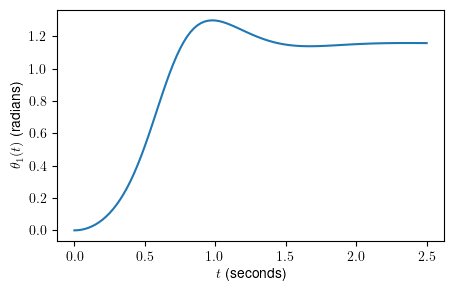

In [55]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(5,3))

ax.plot(sol.t, sol.y[0,:], markeredgewidth=2)
ax.set_xlabel(" $t$ (seconds) ")
ax.set_ylabel(" $\\theta_1 (t) $ (radians) ")
plt.show()

<IPython.core.display.Javascript object>


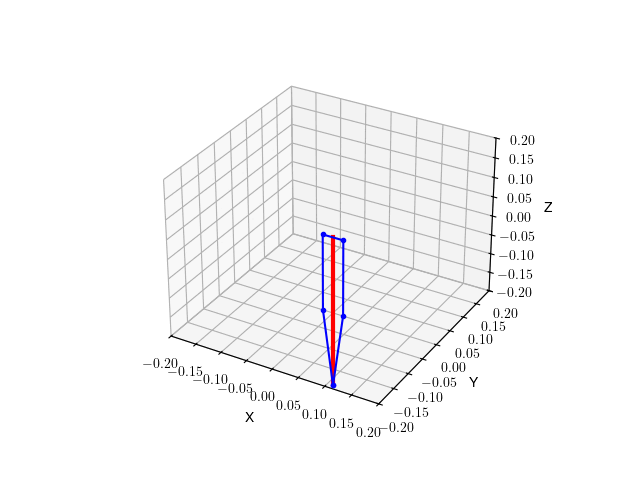

In [56]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

# Collect the points 
N = len(sol.t)
th1_array = sol.y[0,:]
th2_array = RPM_ * sol.t

# Plotting starts here
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Create lines initially
E = np.array([0., 0., 0.])  
F = np.array([0., 0., -2*l_])
rod  = ax.plot([E[0], F[0]], [E[1], F[1]], [E[2], F[2]], '-r', linewidth=3.0 )[0]
arms = ax.plot([], [], [], '.-b')[0] # without data

# Setting the Axes properties
ax.set(xlim3d=(-0.2, 0.2), xlabel='X')
ax.set(ylim3d=(-0.2, 0.2), ylabel='Y')
ax.set(zlim3d=(-0.2, 0.2), zlabel='Z')

# --- Animation update callback function ---
def update_lines(num):
    A1 = np.array([-d_*cos(th2_array[num]),-d_*sin(th2_array[num]),0], dtype=np.float32)
    A2 = np.array([ d_*cos(th2_array[num]), d_*sin(th2_array[num]),0], dtype=np.float32)
    B  = np.array([-(l_*sin(th1_array[num])+d_)*cos(th2_array[num]), -(l_*sin(th1_array[num])+d_)*sin(th2_array[num]), -l_*cos(th1_array[num])])
    C  = np.array([(l_*sin(th1_array[num])+d_)*cos(th2_array[num]),  (l_*sin(th1_array[num])+d_)*sin(th2_array[num]), -l_*cos(th1_array[num])])
    D  = np.array([ 0,0, -l_*cos(th1_array[num])*2])
    arms.set_data_3d(np.vstack([D, B, A1, A2, C, D]).T)

    return [arms]
# ---

ani = animation.FuncAnimation(fig, update_lines, N,  interval=1000);
ani.save("./images/flyball.gif",  writer='imagemagick', fps=15);
display_gif("./images/flyball.gif")